In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [1]:
# audio libraries
import librosa
import librosa.display
import IPython.display as ipd  # to display spectra

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# preprocessing
from sklearn.preprocessing import StandardScaler

# ML
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix, classification_report

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

# custom project helper functions
from urban_sound_python.helper_functions import get_filepaths_from_dir
from urban_sound_python.helper_functions import get_filenames_from_dir
from urban_sound_python.helper_functions import get_class_from_meta
from urban_sound_python.plotting import plot_duration_and_count_of_sounds
from urban_sound_python.plotting import plot_duration_for_classes
from urban_sound_python.librosa_feature_generation import calc_chroma, calc_mfcc, calc_zcr, calc_sc, calc_sr, calc_sb, calc_rms
from urban_sound_python.librosa_feature_generation import feats_from_sound, feats_from_sounds, generate_original_dataframe
# config file specifying which features needed to be generated
from urban_sound_python.librosa_feature_config import librosa_config
from urban_sound_python.librosa_feature_config import get_column_headers_from_config

### sns plot aesthetics
sns.set_style("dark")

NameError: name 'calc_chroma' is not defined

In [3]:
# where are all the audio files?
DIR_ALL_AUDIO = './data/all'

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Inspect the database

In [4]:
# run this to store all paths to all audio files in a list
all_audio_path_list = get_filepaths_from_dir(DIR_ALL_AUDIO)
all_audio_filenames = get_filenames_from_dir(DIR_ALL_AUDIO)

## Metadata

In [5]:
df_meta = pd.read_csv('./data/UrbanSound8K.csv')

In [6]:
df_meta[df_meta['class']=='jackhammer']

,slice_file_name,fsID,start,end,salience,fold,classID,class
171,103074-7-0-0.wav,103074,3.341279,7.341279,1,1,7,jackhammer
172,103074-7-0-1.wav,103074,3.841279,7.841279,1,1,7,jackhammer
173,103074-7-0-2.wav,103074,4.341279,8.341279,1,1,7,jackhammer
174,103074-7-1-0.wav,103074,22.517317,26.517317,1,1,7,jackhammer
175,103074-7-1-1.wav,103074,23.017317,27.017317,1,1,7,jackhammer
...,...,...,...,...,...,...,...,...
8658,98859-7-2-1.wav,98859,10.374292,14.374292,1,9,7,jackhammer
8659,98859-7-2-2.wav,98859,10.874292,14.874292,1,9,7,jackhammer
8660,98859-7-2-3.wav,98859,11.374292,15.374292,1,9,7,jackhammer
8661,98859-7-2-4.wav,98859,11.874292,15.874292,1,9,7,jackhammer


What am I classifying? What are the unique values?

In [7]:
df_meta['class'].value_counts()

street_music        1000
engine_idling       1000
children_playing    1000
dog_bark            1000
drilling            1000
air_conditioner     1000
jackhammer          1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

In [8]:
df_meta['class'].unique()

array(['dog_bark', 'children_playing', 'car_horn', 'air_conditioner',
       'street_music', 'gun_shot', 'siren', 'engine_idling', 'jackhammer',
       'drilling'], dtype=object)

## Checking for class balancing and time duration of sound snippets

Creating another column for the duration of the sounds

In [9]:
df_meta['duration'] = df_meta['end'] - df_meta['start']

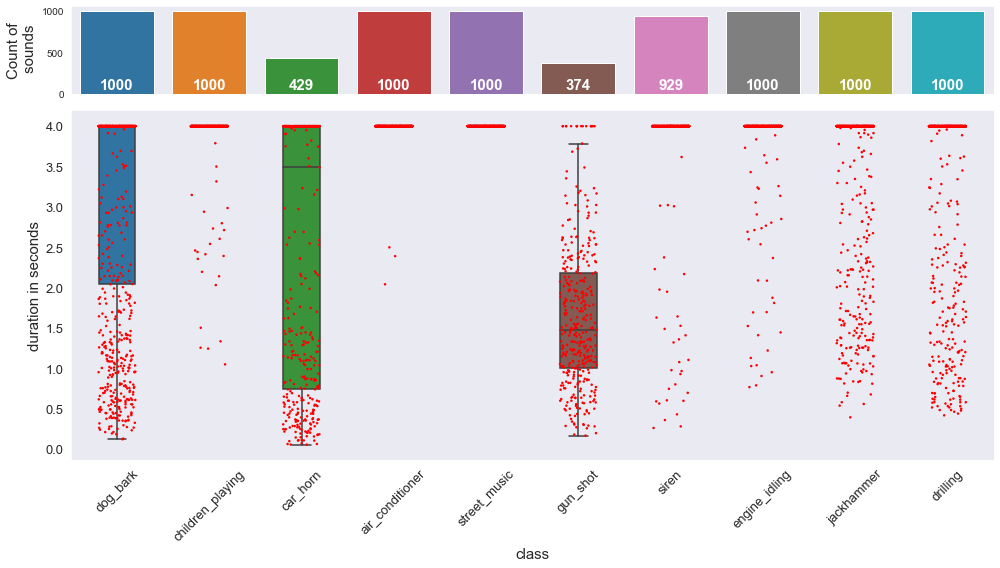

In [10]:
plot_duration_and_count_of_sounds(df_meta)

Observations:
* Except `gun_shot` and `car_horn` all other target categories are fairly balanced

In [11]:
# number of uniqe classes
len(df_meta['class'].value_counts())

10

### Plotting frequency of duration of music files for different classes.

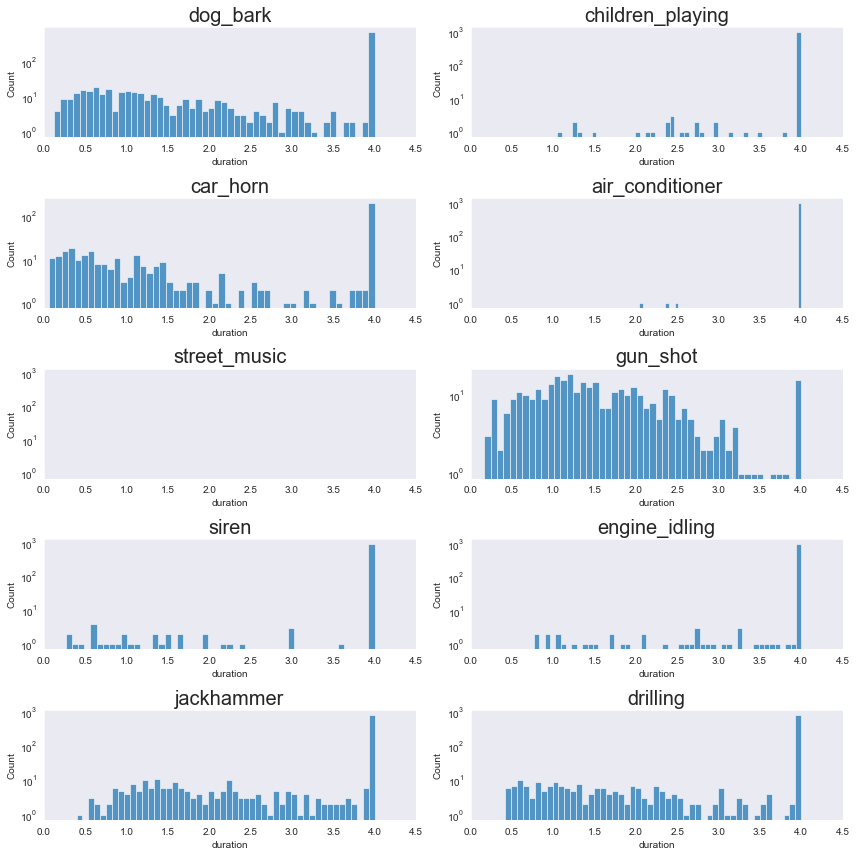

In [12]:
plot_duration_for_classes(df_meta)

# Generate audio features from audio files with the help of librosa

What we're aiming for is a dataframe:
* **rows**: all observations (audio files)
* **columns**: the audio features which we extract as numerical values from the files with librosa. They can be aggregated as statistical measures, e.g. `np.mean`, `np.std` etc.

audio_file_name | feature1 | feature 2 | ... | feature n | class
--- |--- |--- |--- |--- |---
100032-3-0-0.wav | 0.45 | -0.3 | ... | 43.23 | dog_barking
... | ... | ... | ... | ... | ...

* TODO
    * build functions for every desired audio feature to be extracted from one sound
    * define a config dictionary (later YAML?) in which user can provide which feature and which statistical metric (np.mean, np.std, etc.) she wants
    * build function which takes this config dictionary and generates the features for one sound
    * build function which builds a multidimensional array with all audio features for **all** sounds of a provided file path list and a provided config file
    * build function which generates a list of header names for all the columns of that array, with which above dataframe can be generated. Headernames can be of the form `feature_measure`, e.g. `chroma_std`.

### Calculate features for one audio file (audio time series and sampling rate)

Let's test it for one audio file

In [13]:
# load one audio file
y, sr = librosa.core.load(all_audio_path_list[0])

In [14]:
chrom_arr = np.mean(calc_chroma(y, sr), axis=1)

In [15]:
mfcc_arr = np.mean(calc_mfcc(y, sr), axis=1)

Continue loading all files

In [34]:
get_column_headers_from_config(librosa_config)

['chroma_std',
 'chroma_mean',
 'mfcc_std',
 'mfcc_mean',
 'zcr_std',
 'zcr_mean',
 'sc_std',
 'sc_mean',
 'sr_std',
 'sr_mean',
 'sb_std',
 'sb_mean',
 'rms_std',
 'rms_mean']

### Build the dataframe

In [16]:
# this custom function builds the dataframe from a feature config file librosa_config and uses all the audio
# files provided in all_audio_path_list
df_feats = generate_original_dataframe(librosa_config, all_audio_path_list, disable_progress=False)

/home/flo/anaconda3/envs/fin-project3/lib/python3.8/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
/home/flo/anaconda3/envs/fin-project3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(
/home/flo/anaconda3/envs/fin-project3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
/home/flo/anaconda3/envs/fin-project3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(


NameError: name 'get_column_headers_from_config' is not defined

### Pickle resulting dataframe

In [ ]:
# pickle data
pd.to_pickle(df_feats, "./data/df_feats.pkl")

### Unpickle dataframe (start here if you don't want to regenerate the dataframe)

In [17]:
# add filename column and class column
df_feats = pd.read_pickle("./data/df_feats.pkl")

In [18]:
df_feats.head()

,chroma_std,chroma_mean,mfcc_std,mfcc_mean,zcr_std,zcr_mean,sc_std,sc_mean,sr_std,sr_mean,sb_std,sb_mean,rms_std,rms_mean,filename,class
0,0.306090,0.371429,103.695343,-10.487583,0.018313,0.051738,71.987518,730.361316,167.970889,1135.907582,110.704940,1066.102898,0.002671,0.015961,159751-8-0-8.wav,siren
1,0.310757,0.577193,84.661896,-2.623090,0.037075,0.041589,453.239703,1128.429451,1142.178408,2106.208651,309.005205,1747.776761,0.040356,0.049245,49808-3-0-6.wav,dog_bark
2,0.288669,0.324986,37.574150,-0.397206,0.011540,0.071456,138.774597,1563.163963,357.189589,3229.420357,144.701979,1838.907310,0.025321,0.148258,79377-9-0-4.wav,street_music
3,0.296240,0.286259,61.013550,-8.226327,0.028725,0.104484,228.629427,1594.837664,446.762271,2861.239924,107.500296,1539.256136,0.025430,0.054579,171165-9-0-15.wav,street_music
4,0.294393,0.410723,59.436771,-5.889602,0.015472,0.051219,238.341885,1334.639268,704.749720,2613.919261,247.072554,1763.160701,0.037223,0.064975,157940-9-0-2.wav,street_music


In [ ]:
# scaler = StandardScaler()
# scaler.fit(df_feats)
# arr_feats = scaler.transform(df_feats)
# df_feats = pd.DataFrame(data=arr_feats, columns=column_headers)
# df_feats.head()

# EDA

Function to generate boxplots for each feature of each class

In [ ]:
def plot_boxplots_for_classes(class_):
    sns.set(rc={'figure.figsize':(14,8)})
    g = sns.boxplot(x="variable",
                    y="value",
                    data=pd.melt(df_feats[df_feats['class']==class_].drop(['filename','class'], axis=1)),
                    fliersize=1);
    g.set_xticklabels(g.get_xticklabels(),
                      rotation=90,
                     );
    g.set_xlabel('feature');
    g.set_ylabel('value');
    g.set_title(class_, fontdict={'fontsize':20})
    plt.show()

### generate the boxplots

In [ ]:
[plot_boxplots_for_classes(class_) for class_ in df_feats['class'].unique()]

In [ ]:
df_feats_melt = pd.melt(df_feats.drop(['filename'], axis=1), id_vars='class').rename(columns={'variable':'feature'})

In [ ]:
df_feats_melt.head()

### Boxplots for each class next to each other per feature

In [ ]:
sns.set(rc={'figure.figsize':(14,35)})
sns.boxplot(y="feature",
            x="value",
            hue="class",
            data=df_feats_melt,
            palette="Pastel1",
            fliersize=2,
            width=.5,
           )
plt.show()

# Predict the class!

### Random forest, first iteration

In [ ]:
df = pd.read_pickle("./data/df_feats.pkl")

In [ ]:
df.head()

In [ ]:
X = df.drop(['filename', 'class'], axis=1)
y = df['class']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

For the first iteration, let's choose the standard RandomForestClassifier with default values
* `n_estimators=100`,
* `criterion='gini'`,
* `max_depth=None`,
* `min_samples_split=2`,
* `min_samples_leaf=1`,
* `min_weight_fraction_leaf=0.0`,
* `max_features='auto'`,
* `max_leaf_nodes=None`,
* `min_impurity_decrease=0.0`,
* `min_impurity_split=None`,
* `bootstrap=True`,
* `oob_score=False`,
* `n_jobs=None`,
* `random_state=None`,
* `verbose=0`,
* `warm_start=False`,
* `class_weight=None`,
* `ccp_alpha=0.0`,
* `max_samples=None`,

In [ ]:
forest_clf = RandomForestClassifier(random_state=42)

In [ ]:
forest_clf.fit(X_train, y_train)

In [ ]:
y_pred = forest_clf.predict(X_test)

accuracy_score(y_test, y_pred)

In [ ]:
y_labels = list(y_test.unique())

In [ ]:
# calculate the confusion matrix
cnf_mat = confusion_matrix(y_test, y_pred, labels=y_labels)

# plot
sns.set(rc={'figure.figsize':(10,10)})
g = sns.heatmap(cnf_mat,
            annot=True,
            fmt='d',
            xticklabels=y_labels,
            yticklabels=y_labels,
           );
g.set_title("Classification results");
g.set_xlabel("predicted");
g.set_ylabel("true");

Observations:
* With an accuracy score of 82% for the test data, this is already a fairly decent model

In [ ]:
row_sums = cnf_mat.sum(axis=1, keepdims=True)
norm_cnf_mat = cnf_mat / row_sums

# fill diagonal with zeros
np.fill_diagonal(norm_cnf_mat, 0)
g = sns.heatmap(norm_cnf_mat,
            annot=True,
            #fmt='d',
            xticklabels=y_labels,
            yticklabels=y_labels,
                cmap=plt.cm.gray,
           );
g.set_title("Classification errors (sum of all predictions = 1), main diagonal set to 0");
g.set_xlabel("predicted");
g.set_ylabel("true");

What we can observe here: `dog_bark`, `street_music` and `car_horn` is relatively often mistaken by the model as `children_playing`. 
* **TODO** So let's look at those features specifically and try to find something that distinguishes them

In [ ]:
df_selected = df_feats_melt[df_feats_melt['class'].isin(['dog_bark', 'street_music', 'car_horn', 'children_playing'])]

In [ ]:
sns.set(rc={'figure.figsize':(14,35)})
sns.boxplot(y="feature",
            x="value",
            hue="class",
            data=df_selected,
            palette="Pastel1",
            fliersize=2,
            width=.5,
           )
plt.show()

* high overlap in `chroma_std`, `zcr_std`, `sc_mean`, `sr_mean`, `sb_mean`

In [ ]:
import matplotlib.pyplot as plt

from collections import OrderedDict

RANDOM_STATE = 123

ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
#    ("RandomForestClassifier, max_features=None",
#        RandomForestClassifier(warm_start=True, max_features=None,
#                               oob_score=True,
#                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 400
max_estimators = 3000

for label, clf in ensemble_clfs:
    for i in tqdm(range(min_estimators, max_estimators + 1)):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

In [ ]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
sns.set(rc={'figure.figsize':(12,10)})
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [ ]:
pd.to_pickle(ensemble_clfs, './data/ensemble_clfs_sqrt_log2.pkl')

In [ ]:
pd.to_pickle(error_rate, "./data/error_rate_ordered_dct.pkl")

What's the number of estimators with the minimum error rate?

In [ ]:
import operator
min([err for _, clf_err in error_rate.items() for err in clf_err], key=operator.itemgetter(1))

Let's use 2043 then as the `n_estimators` parameter

In [ ]:
rfc_tuned = RandomForestClassifier(max_features="sqrt",random_state=RANDOM_STATE, n_estimators=2043)
rfc_tuned.fit(X_train, y_train)
y_pred = rfc_tuned.predict(X_test)

accuracy_score(y_test, y_pred)

2 percent increase \o/

## Model optimization approaches

* Hyperparameter tuning (ensemble methods, number of trees etc. ...)
* Feature inspection: Why are some classes confused with some specific classes more than with others. Generate features that distinguish them
* Build a *hard-voting-classifier* out of several algorithms - Predictions are then majority votes (`from sklearn.ensemble import VotingClassifier`)

# Pipeline approach (with k-fold cross validation)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

# numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', StandardScaler())])

# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# numeric_features = train.select_dtypes(include=['int64', 'float64']).columns
# categorical_features = train.select_dtypes(include=['object']).drop(['Loan_Status'], axis=1).columns

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numeric_features),
#         ('cat', categorical_transformer, categorical_features)
#     ])

# pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', RandomForestClassifier())])

df = pd.read_pickle("./data/df_feats.pkl")
X = df.drop(['filename', 'class'], axis=1)
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)
# smoting
smote = SMOTE(random_state = 11)
X_train, y_train = smote.fit_resample(X_train, y_train)

pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                             ['classifier', RandomForestClassifier(bootstrap=True)]])

In [ ]:
pipeline.get_params().keys()

In [ ]:
stratified_kfold = StratifiedKFold(n_splits=8,
                                   shuffle=True,
                                   random_state=11,
                                  )


param_grid = {'classifier__n_estimators':[200, 250, 300, 350, 400, 450, 500],
              'classifier__max_features':['auto', 'sqrt', 'log2'],
              'classifier__max_depth':[4,5,6,7,8, None],
              'classifier__criterion':['gini', 'entropy'],
             }


grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='f1_weighted',  # because multiclass problem
                           cv=stratified_kfold,
                           n_jobs=-1,
                           verbose=4,
                          )

grid_search.fit(X_train, y_train)

cv_score = grid_search.best_score_
best_params = grid_search.best_params_

test_score = grid_search.score(X_test, y_test)

print(f'Cross-validation score: {cv_score}\n'
      f'Test score: {test_score}\n'
      f'Best params: {best_params}\n'
     )



# define pipeline
# rf = Pipeline(steps=[('preprocessor', preprocessor),
#                      ('classifier', RandomForestClassifier())])

# apply pipeline (including model fitting)
# rf.fit(X_train, y_train)

# y_pred = rf.predict(X_test)

In [ ]:
grid_search.cv_results_

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)
# smoting
smote = SMOTE(random_state = 11)
X_train, y_train = smote.fit_resample(X_train, y_train)

pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                             ['classifier', RandomForestClassifier(bootstrap=True,
                                                                  criterion='entropy',
                                                                  n_estimators=500)]])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [ ]:
y_labels = list(y_test.unique())

# calculate the confusion matrix
cnf_mat = confusion_matrix(y_test, y_pred, labels=y_labels)

# plot
sns.set(rc={'figure.figsize':(10,10)})
g = sns.heatmap(cnf_mat,
            annot=True,
            fmt='d',
            xticklabels=y_labels,
            yticklabels=y_labels,
           );
g.set_title("Classification results");
g.set_xlabel("predicted");
g.set_ylabel("true");

In [ ]:
accuracy_score(y_test, y_pred)